# Rotational variance/invariance ?? 

As of 26 november the simulations online are not working even when we trained using MOM6 as input. 
So we are checking if adding rotational equivariance may help. 

We can check rotation quite easily using: https://www.continuummechanics.org/rotationmatrix.html 

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

import xgcm

import optax
from flax.training import train_state
from flax.training import checkpoints

import sys
sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

# Import seaborn
import seaborn as sns

In [2]:
data_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day/'

In [72]:
Lsel = '200'

ds = xr.open_zarr(f'{data_bucket}ml_data_'+Lsel+'km.zarr').sel(yh=slice(float(Lsel), 1600-float(Lsel)))

### ANN predictions

In [73]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  'Sx', 'Sy', 'Lfilt']

In [74]:
#size_name = 'small'
#layer_sizes = [24, 24, 2]

size_name = 'medium'
layer_sizes = [32, 32, 2]

#size_name = 'large'
#layer_sizes = [64, 64, 2]

model, params = ml_hf.initialize_model(layer_sizes, len(input_channels) )

learning_rate = .01
tx = optax.adam(learning_rate=learning_rate)

state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

# Read back from the checkpoint
CKPT_DIR = '../train_models/train_on_MOM6_data/ckpts_single_all_res_' + size_name
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
ANN_nc = xr.open_dataset('../train_models/train_on_MOM6_data/ann_params_all_res_'+size_name+'.nc')

In [75]:
ANN_nc.input

<xarray.DataArray 'input' (input: 7)>
array([0, 1, 2, 3, 4, 5, 6])
Dimensions without coordinates: input

In [76]:
def ML_vars(ds_L, L, choice=1):
    
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    #choice = 0 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    return ds_test

In [77]:
def ANN_pred(ds_test, L):
     
    input_norms = ANN_nc.input_norms.rename({'input':'variable'})
    output_norms = ANN_nc.output_norms.rename({'output':'variable'})
    
    #ds_test_small = ds_test.isel(Time=slice(0,None)).sel(yh=slice(L, 1600-L))
    
    ds_input = ds_test[input_channels].to_array().transpose(...,'variable')/input_norms
    
    ds_output = ds_test[output_channels].to_array().transpose(...,'variable')#/output_norms
    
    x0 = np.zeros(7)
    x0[6] = L/input_norms[6]
    y_0 = state.apply_fn(state.params, x0)
    y_0
    
    y_pred = state.apply_fn(state.params, ds_input) 
    
    ds_pred = xr.DataArray(y_pred, dims = ds_output.dims, coords = ds_output.coords)*output_norms
    ds_pred_no_bias = xr.DataArray(y_pred-y_0, dims = ds_output.dims, coords = ds_output.coords)*output_norms
    
    return ds_pred_no_bias.to_dataset('variable'), ds_pred.to_dataset('variable')

In [78]:
ds_ML = ML_vars(ds, int(Lsel))

In [79]:
_, ds_pred = ANN_pred(ds_ML, int(Lsel))

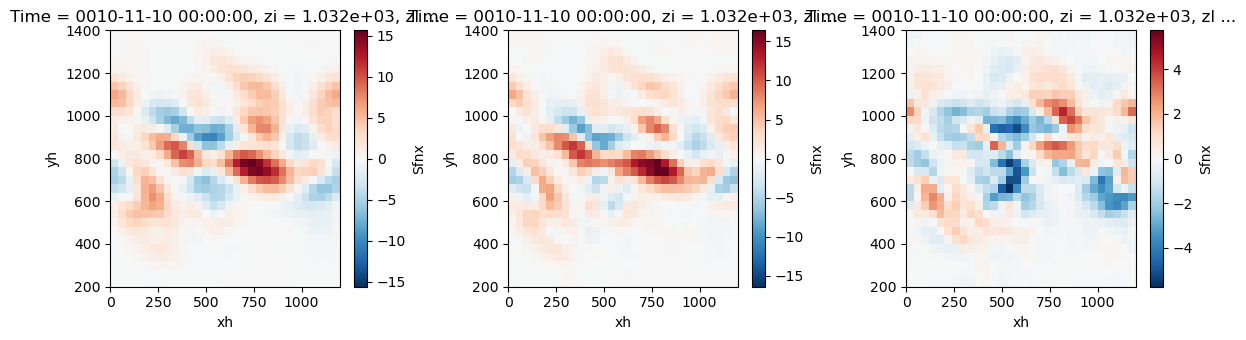

In [80]:
plt.figure(figsize=(12, 3.5))

plt.subplot(131)
ds_ML.isel(Time=-1).Sfnx.plot()

plt.subplot(132)
ds_pred.isel(Time=-1).Sfnx.plot()

plt.subplot(133)
(ds_ML - ds_pred).isel(Time=-1).Sfnx.plot()

plt.tight_layout()

### Rotate some variables

In [81]:
def rotate_scalar_90(ds, e='e'): 
    
    e_rotate = xr.DataArray(ds[e].values, 
                              dims=['Time','zi','xh','yh'],
                              coords={'Time':ds.Time, 
                                      'zi':ds.zi,
                                      'xh': -ds.yh.values,
                                      'yh': ds.xh.values})
    return e_rotate

In [82]:
def rotate_vector_90(ds, u='u', v='v', zdim='zl'): 
    
    #zdim = 
    # Vector rotation 
    #ds_rotate = xr.Dataset()
    if zdim == 'zl': 
        u_rotate = xr.DataArray(- ds[v].values, 
                              dims=['Time',zdim,'xh','yh'],
                              coords={'Time':ds.Time, 
                                      zdim:ds[zdim],
                                      'xh': -ds.yh.values,
                                      'yh': ds.xh.values})
        v_rotate = xr.DataArray(ds[u].values, 
                              dims=['Time',zdim,'xh','yh'],
                              coords={'Time':ds.Time, 
                                      zdim:ds[zdim],
                                      'xh': -ds.yh.values,
                                      'yh': ds.xh.values})
    else: 
        u_rotate = xr.DataArray(- ds[v].values, 
                              dims=['Time','xh','yh'],
                              coords={'Time':ds.Time, 
                                      #zdim:ds[zdim],
                                      'xh': -ds.yh.values,
                                      'yh': ds.xh.values})
        v_rotate = xr.DataArray(ds[u].values, 
                              dims=['Time','xh','yh'],
                              coords={'Time':ds.Time, 
                                      #zdim:ds[zdim],
                                      'xh': -ds.yh.values,
                                      'yh': ds.xh.values})
    return u_rotate, v_rotate

In [83]:
def rotate_tensor_90(ds, u_x='U_x', u_y='U_y', v_x='V_x', v_y='V_y'): 
    
    u_x_rotate = xr.DataArray( ds[v_y].values, 
                          dims=['Time','xh','yh'],
                          coords={'Time':ds.Time, 
                                  #zdim:ds[zdim],
                                  'xh': -ds.yh.values,
                                  'yh': ds.xh.values})
    u_y_rotate = xr.DataArray(- ds[v_x].values, 
                          dims=['Time','xh','yh'],
                          coords={'Time':ds.Time, 
                                  #zdim:ds[zdim],
                                  'xh': -ds.yh.values,
                                  'yh': ds.xh.values})
    
    v_x_rotate = xr.DataArray( -ds[u_y].values, 
                          dims=['Time','xh','yh'],
                          coords={'Time':ds.Time, 
                                  #zdim:ds[zdim],
                                  'xh': -ds.yh.values,
                                  'yh': ds.xh.values})
    v_y_rotate = xr.DataArray( ds[u_x].values, 
                          dims=['Time','xh','yh'],
                          coords={'Time':ds.Time, 
                                  #zdim:ds[zdim],
                                  'xh': -ds.yh.values,
                                  'yh': ds.xh.values})
    
    
    return u_x_rotate, u_y_rotate, v_x_rotate, v_y_rotate

In [84]:
ds_rotate = xr.Dataset()
ds_rotate['u'], ds_rotate['v'] = rotate_vector_90(ds)
ds_rotate['e'] = rotate_scalar_90(ds)

In [85]:
def plot_fields(ds, idT=0): 
    plt.figure(figsize=(12, 3.5)) 

    ds_plot = ds

    plt.subplot(131)
    ds_plot.e.isel(Time=idT, zi=1).plot(x='xh')
    plt.title('e')

    plt.subplot(132)
    ds_plot.u.isel(Time=idT, zl=1).plot(x='xh')
    plt.title('u')

    plt.subplot(133)
    ds_plot.v.isel(Time=idT, zl=1).plot(x='xh')
    plt.title('v')

    plt.tight_layout()

In [98]:
ds_ML = ML_vars(ds, int(Lsel), choice=1)

In [99]:
ds_ML_rotate = xr.Dataset()

ds_ML_rotate['Sx'], ds_ML_rotate['Sy'] = rotate_vector_90(ds_ML, 'Sx', 'Sy', zdim=None)
ds_ML_rotate['Sfnx'], ds_ML_rotate['Sfny'] = rotate_vector_90(ds_ML, 'Sfnx', 'Sfny', zdim=None)
ds_ML_rotate['U_x'], ds_ML_rotate['U_y'], ds_ML_rotate['V_x'], ds_ML_rotate['V_y'] = rotate_tensor_90(ds_ML)
ds_ML_rotate['Lfilt'] = ds_ML_rotate.Sx*0. + int(Lsel)

In [100]:
def plot_ML(ds, idT=0):
    plt.figure(figsize=(16, 6))

    ds_plot = ds

    plt.subplot(241)
    ds_plot['U_x'].isel(Time=idT).plot(x='xh')
    plt.title('U_x')

    plt.subplot(245)
    ds_plot['V_x'].isel(Time=idT).plot(x='xh')
    plt.title('V_x')

    plt.subplot(242)
    ds_plot['U_y'].isel(Time=idT).plot(x='xh')
    plt.title('U_y')

    plt.subplot(246)
    ds_plot['V_y'].isel(Time=idT).plot(x='xh')
    plt.title('V_y')

    plt.subplot(243)
    ds_plot['Sx'].isel(Time=idT).plot(x='xh')
    plt.title('Sx')

    plt.subplot(247)
    ds_plot['Sy'].isel(Time=idT).plot(x='xh')
    plt.title('Sy')

    plt.subplot(244)
    ds_plot['Sfnx'].isel(Time=idT).plot(x='xh')
    plt.title('Sfnx')

    plt.subplot(248)
    ds_plot['Sfny'].isel(Time=idT).plot(x='xh')
    plt.title('Sfny')

    plt.tight_layout()

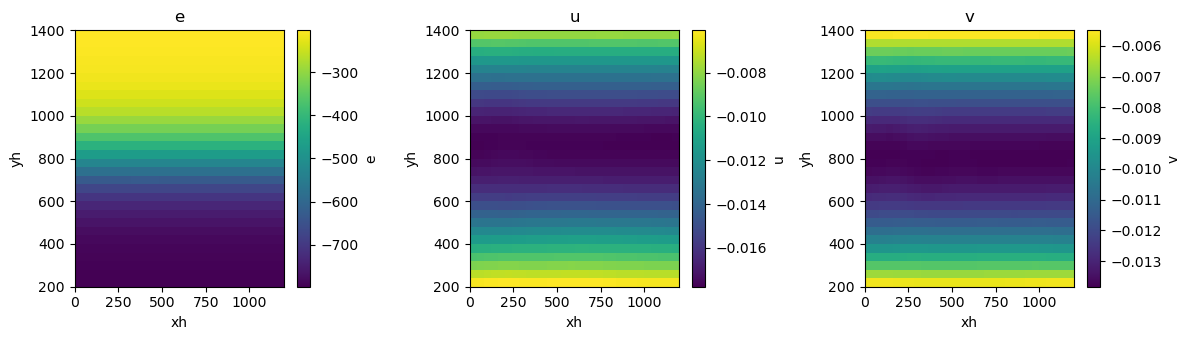

In [101]:
plot_fields(ds, idT=0)

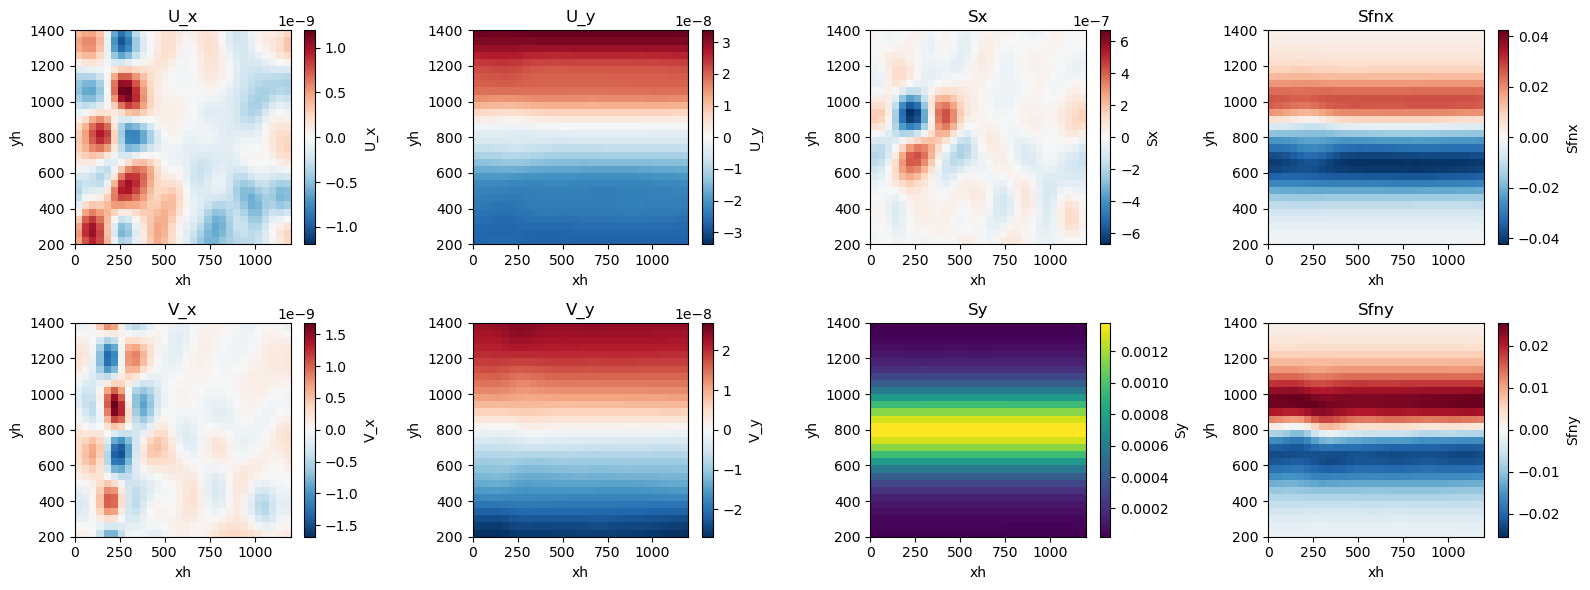

In [102]:
plot_ML(ds_ML, 0)

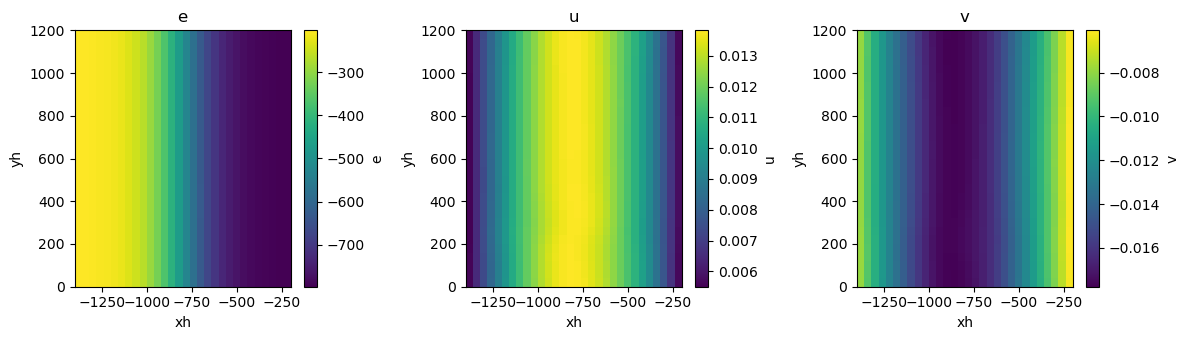

In [103]:
plot_fields(ds_rotate, idT=0)

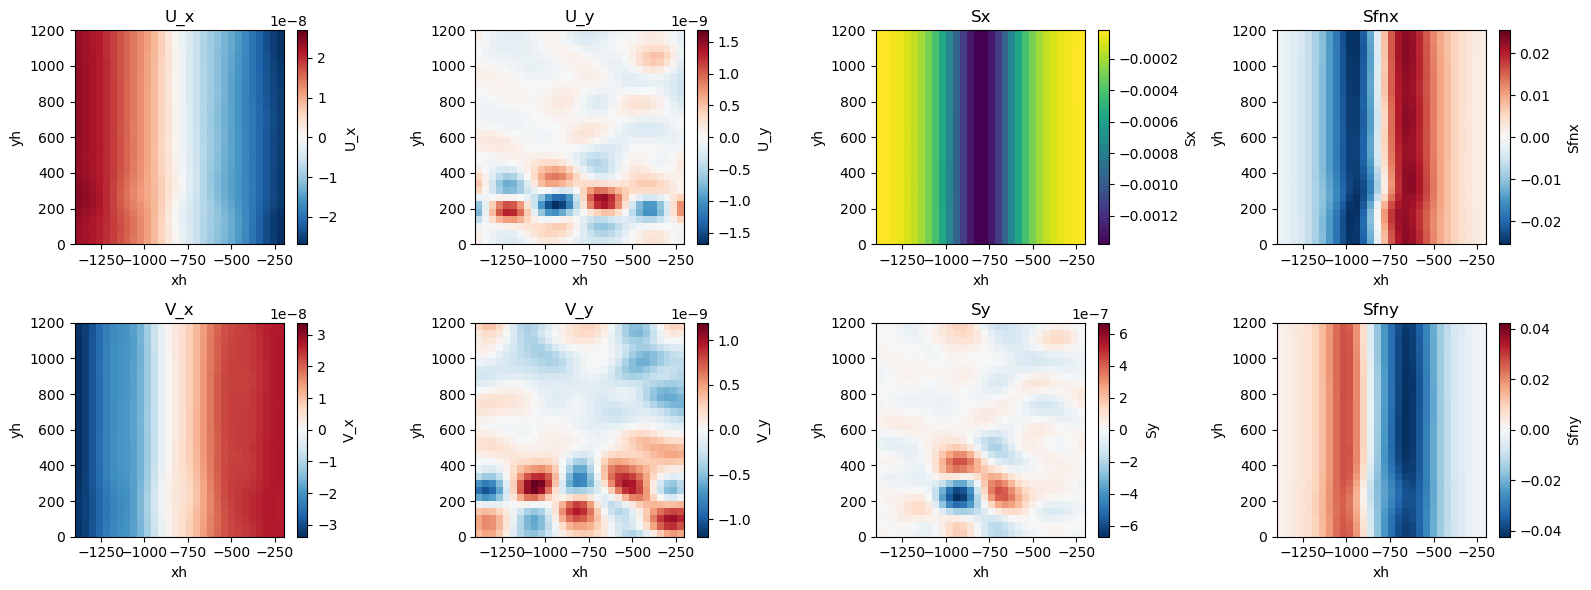

In [104]:
plot_ML(ds_ML_rotate, 0)

Rotaion of fields seems fine. 

In [105]:
_, ds_pred = ANN_pred(ds_ML, int(Lsel))

In [106]:
_, ds_pred_rotate = ANN_pred(ds_ML_rotate, int(Lsel))

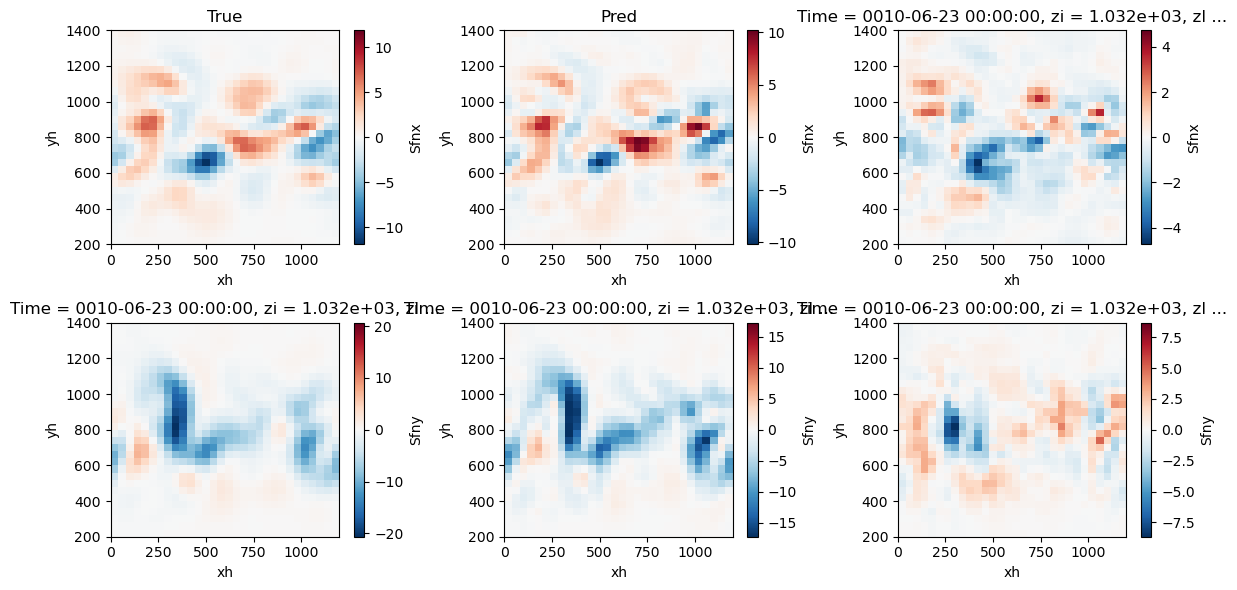

In [107]:
plt.figure(figsize=(12, 6))
idT = -15

plt.subplot(231)
ds_ML.isel(Time=idT).Sfnx.plot()
plt.title('True')

plt.subplot(232)
ds_pred.isel(Time=idT).Sfnx.plot()
plt.title('Pred')

plt.subplot(233)
(ds_ML - ds_pred).isel(Time=idT).Sfnx.plot()

plt.subplot(234)
ds_ML.isel(Time=idT).Sfny.plot()

plt.subplot(235)
ds_pred.isel(Time=idT).Sfny.plot()

plt.subplot(236)
(ds_ML - ds_pred).isel(Time=idT).Sfny.plot()

plt.tight_layout()

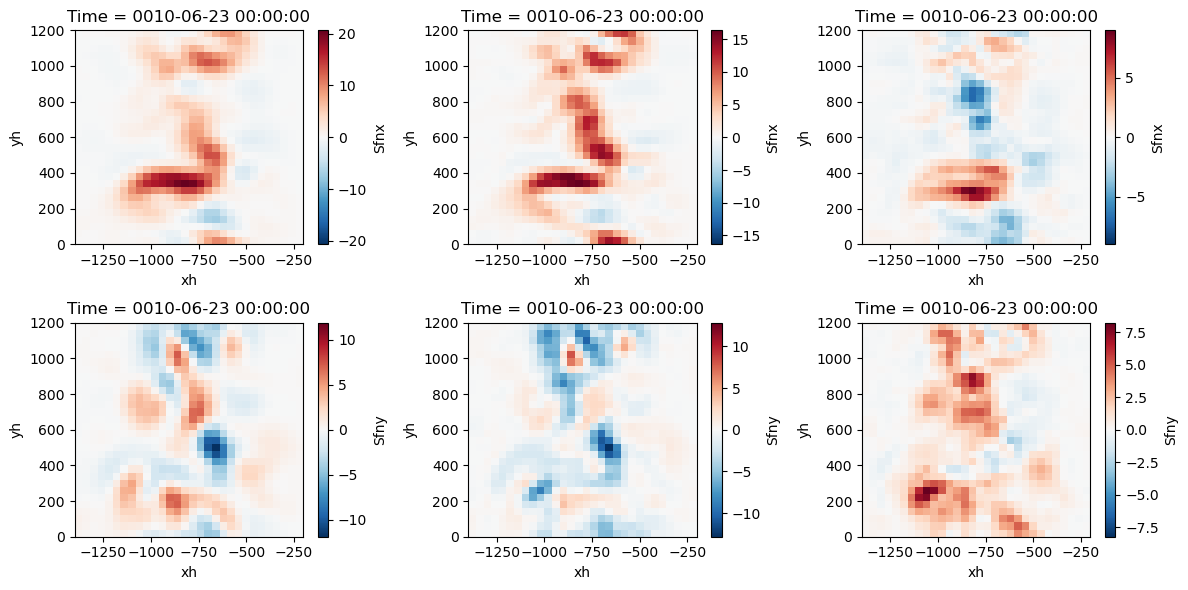

In [108]:
plt.figure(figsize=(12, 6))

plt.subplot(231)
ds_ML_rotate.isel(Time=idT).Sfnx.plot(x='xh')

plt.subplot(232)
ds_pred_rotate.isel(Time=idT).Sfnx.plot(x='xh')

plt.subplot(233)
(ds_ML_rotate - ds_pred_rotate).isel(Time=idT).Sfnx.plot(x='xh')

plt.subplot(234)
ds_ML_rotate.isel(Time=idT).Sfny.plot(x='xh')

plt.subplot(235)
ds_pred_rotate.isel(Time=idT).Sfny.plot(x='xh')

plt.subplot(236)
(ds_ML_rotate - ds_pred_rotate).isel(Time=idT).Sfny.plot(x='xh')

plt.tight_layout()

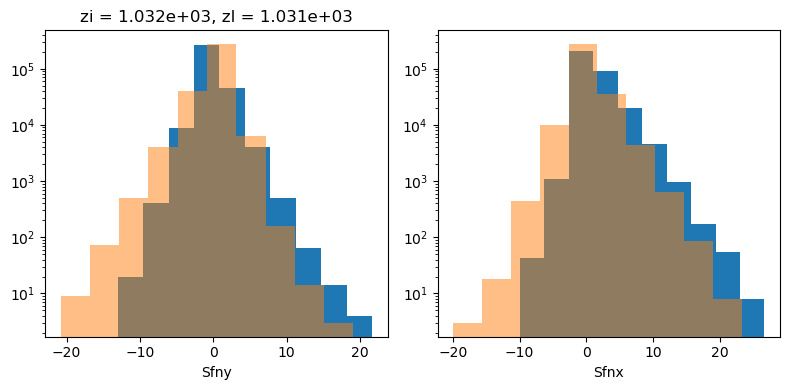

In [109]:
plt.figure(figsize=(8, 4)) 

plt.subplot(121)
(ds_ML - ds_pred).Sfnx.plot.hist();
(ds_ML - ds_pred).Sfny.plot.hist(alpha=0.5);
plt.yscale('log')

plt.subplot(122)
(ds_ML_rotate - ds_pred_rotate).Sfny.plot.hist();
(ds_ML_rotate - ds_pred_rotate).Sfnx.plot.hist(alpha=0.5);
plt.yscale('log')

plt.tight_layout()